### 구현 모델 : 현재 온도, 습도, 재실인원에 따른 에어컨 ON/OFF 여부 판별 AI 모델

In [264]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from influxdb_client import InfluxDBClient
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np
import os

### 데이터 수집
- InfluxDB에 접속하여 필요한 센서 데이터 가져오기

In [265]:
# InfluxDB 접속 정보 불러오기
load_dotenv()

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [266]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement, place):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "experimental/query"
    from(bucket: "{DB_BUCKET}")
    |> range(start: date.sub(d: 5d, from: date.truncate(t: now(), unit: 1d)), stop: now())
    |> filter(fn: (r) => r["_measurement"] == "{measurement}")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r.place == "{place}")
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{place} {measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

outdoor_temperature_df = query_influx("temperature", "outdoor")
outdoor_humidity_df = query_influx("humidity", "outdoor")
temperature_df = query_influx("temperature", "class_a")
humidity_df = query_influx("humidity", "class_a")
people_count_df = query_influx("total_people_count", "class_a")
magnet_status_df = query_influx("magnet_status", "class_a")


outdoor temperature shape:  (761, 10)
outdoor humidity shape:  (761, 10)
class_a temperature shape:  (20774, 10)
class_a humidity shape:  (20774, 10)
class_a total_people_count shape:  (14576, 10)
class_a magnet_status shape:  (786, 10)


### 데이터 전처리
- 필요없는 컬럼 삭제 및 한국시간대로 시간대 변환, 주말 데이터는 매우 불규칙하므로 삭제
- 결측치 처리

In [267]:
def clean_and_convert_time(df):
    df = df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)
    df = df[df['_time'].dt.dayofweek < 5]
    return df

temperature_outdoor_df = clean_and_convert_time(outdoor_temperature_df)
humidity_outdoor_df = clean_and_convert_time(outdoor_humidity_df)
temperature_class_a_df = clean_and_convert_time(temperature_df)
humidity_class_a_df = clean_and_convert_time(humidity_df)
people_count_df = clean_and_convert_time(people_count_df)
magnet_status_df = clean_and_convert_time(magnet_status_df)

In [268]:
# resample로 1분단위로 데이터를 합치기 위해 Datetime을 인덱스로 지정
# value에 대해 1분 단위로 평균 or 마지막값 계산.
def resample_data(df, column, freq, method):
    df = df.set_index('_time')

    if method == 'mean':
        return df[column].resample(freq).mean()
    elif method == 'last':
        return df[column].resample(freq).last()

outdoor_temperature_summary_series = resample_data(temperature_outdoor_df, 'value', 'T', 'mean')
outdoor_humidity_summary_series = resample_data(humidity_outdoor_df, 'value', 'T', 'mean')
temperature_summary_series = resample_data(temperature_class_a_df, 'value', 'T', 'mean')
humidity_summary_series = resample_data(humidity_class_a_df, 'value', 'T', 'mean')
people_count_series = resample_data(people_count_df, 'value', 'T', 'last')
magnet_status_series = resample_data(magnet_status_df, 'value', 'T', 'last')

print(outdoor_temperature_summary_series.head(),'\n', outdoor_humidity_summary_series.head(),'\n', temperature_summary_series.head(),'\n', humidity_summary_series.head(),'\n', people_count_series.head(),'\n',magnet_status_series.head(),'\n')

_time
2024-04-24 09:08:00    16.4
2024-04-24 09:09:00     NaN
2024-04-24 09:10:00     NaN
2024-04-24 09:11:00     NaN
2024-04-24 09:12:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-24 09:08:00    67.5
2024-04-24 09:09:00     NaN
2024-04-24 09:10:00     NaN
2024-04-24 09:11:00     NaN
2024-04-24 09:12:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-24 09:00:00    23.650000
2024-04-24 09:01:00    23.300000
2024-04-24 09:02:00    23.650000
2024-04-24 09:03:00    23.233333
2024-04-24 09:04:00    23.550000
Freq: T, Name: value, dtype: float64 
 _time
2024-04-24 09:00:00    46.000000
2024-04-24 09:01:00    47.333333
2024-04-24 09:02:00    46.000000
2024-04-24 09:03:00    47.333333
2024-04-24 09:04:00    46.000000
Freq: T, Name: value, dtype: float64 
 _time
2024-04-24 09:00:00    4.0
2024-04-24 09:01:00    4.0
2024-04-24 09:02:00    4.0
2024-04-24 09:03:00    2.0
2024-04-24 09:04:00    5.0
Freq: T, Name: value, dtype: float64 
 _time
2024-04-24 09:08:00    o

In [269]:
data_df = pd.DataFrame({
    'outdoor_temperature': outdoor_temperature_summary_series,
    'outdoor_humidity': outdoor_humidity_summary_series,
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df.info)

<bound method DataFrame.info of                      outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-24 09:00:00                  NaN               NaN    23.650000   
2024-04-24 09:01:00                  NaN               NaN    23.300000   
2024-04-24 09:02:00                  NaN               NaN    23.650000   
2024-04-24 09:03:00                  NaN               NaN    23.233333   
2024-04-24 09:04:00                  NaN               NaN    23.550000   
...                                  ...               ...          ...   
2024-04-29 17:16:00                  NaN               NaN    24.150000   
2024-04-29 17:17:00                 18.0              70.5    23.833333   
2024-04-29 17:18:00                  NaN               NaN    24.150000   
2024-04-29 17:19:00                  NaN               NaN    23.866666   
2024-04-29 17:20:00                  NaN               NaN    24.000

In [270]:
null_values = data_df.isnull().sum()
print('Initial null value:\n', null_values)

# 'air_conditional' 컬럼의 첫 번째 값이 결측치인 경우 'close'로 설정
if pd.isna(data_df['air_conditional'].iloc[0]):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'

if pd.isna(data_df['outdoor_temperature'].iloc[0]):
    avg_temperature = data_df['outdoor_temperature'].mean()
    data_df.at[data_df.index[0], 'outdoor_temperature'] = avg_temperature

if pd.isna(data_df['outdoor_humidity'].iloc[0]):
    avg_humidity = data_df['outdoor_humidity'].mean()
    data_df.at[data_df.index[0], 'outdoor_humidity'] = avg_humidity

# people_count' 컬럼에서 첫 번째 값이 결측치인 경우, 최근 유효 값으로 채우기
if pd.isna(data_df['people_count'].iloc[0]):
    notnull_peoplecount = data_df[data_df['people_count'].notnull()].iloc[0]['people_count']
    data_df.at[data_df.index[0], 'people_count'] = notnull_peoplecount

# 나머지 결측치 전방 채우기
data_df_filled = data_df.fillna(method='ffill', axis=0)

print('After processing null value: \n', data_df_filled.isnull().sum())

Initial null value:
 outdoor_temperature    7227
outdoor_humidity       7227
temperature            2922
humidity               2922
people_count           2949
air_conditional        7215
dtype: int64
After processing null value: 
 outdoor_temperature    0
outdoor_humidity       0
temperature            0
humidity               0
people_count           0
air_conditional        0
dtype: int64


In [271]:
# 복사본 생성
data_df_filter_by_environment = data_df_filled.copy()
data_df_filter_by_time = data_df_filled.copy()

### 환경에 따른 에어컨 사용량 분석을 위한 전처리
- 날짜값제거, 시간 정보만 사용
- datetime 객체를 분석을 위해 수치형 데이터로 변환 필요. -> 자정으로부터 경과한 분으로 변환
- air_conditional 컬럼의 데이터분석을 위해 수치형 데이터로 변환 필요. close면 0, open이면 1로 변경
- 상관계수 확인
- 다중공선성 진단

In [272]:
# 날짜값 제거
data_df_filter_by_environment.index = data_df_filter_by_environment.index.time
print(data_df_filter_by_environment.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            18.985865         59.459916    23.650000  46.000000   
09:01:00            18.985865         59.459916    23.300000  47.333333   
09:02:00            18.985865         59.459916    23.650000  46.000000   
09:03:00            18.985865         59.459916    23.233333  47.333333   
09:04:00            18.985865         59.459916    23.550000  46.000000   

          people_count air_conditional  
09:00:00           4.0           close  
09:01:00           4.0           close  
09:02:00           4.0           close  
09:03:00           2.0           close  
09:04:00           5.0           close  


In [273]:
# 자정으로부터 경과한 분을 계산하기 위한 처리
data_df_filter_by_environment['time'] = data_df_filter_by_environment.index

# 'time' 컬럼의 datetime.time 객체를 분으로 변환하는 함수
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# 'time' 컬럼을 하루 중 분으로 변환
data_df_filter_by_environment['time_in_minutes'] = data_df_filter_by_environment['time'].apply(time_to_minutes)
data_df_filter_by_environment = data_df_filter_by_environment.drop(columns=['time'])

In [274]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filter_by_environment['air_conditional'] = data_df_filter_by_environment['air_conditional'].map({'close': 0, 'open': 1})
print(data_df_filter_by_environment.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            18.985865         59.459916    23.650000  46.000000   
09:01:00            18.985865         59.459916    23.300000  47.333333   
09:02:00            18.985865         59.459916    23.650000  46.000000   
09:03:00            18.985865         59.459916    23.233333  47.333333   
09:04:00            18.985865         59.459916    23.550000  46.000000   

          people_count  air_conditional  time_in_minutes  
09:00:00           4.0                0              540  
09:01:00           4.0                0              541  
09:02:00           4.0                0              542  
09:03:00           2.0                0              543  
09:04:00           5.0                0              544  


In [275]:
# 내외부 온도, 습도, 사람수에 따른 상관계수 계산
correlation_matrix = data_df_filter_by_environment.corr()
print(correlation_matrix)

                     outdoor_temperature  outdoor_humidity  temperature  \
outdoor_temperature             1.000000         -0.301908     0.585576   
outdoor_humidity               -0.301908          1.000000    -0.475592   
temperature                     0.585576         -0.475592     1.000000   
humidity                        0.073655          0.853654    -0.312588   
people_count                    0.197889         -0.302087     0.341232   
air_conditional                 0.378050         -0.192432     0.237632   
time_in_minutes                 0.381141         -0.138409     0.432619   

                     humidity  people_count  air_conditional  time_in_minutes  
outdoor_temperature  0.073655      0.197889         0.378050         0.381141  
outdoor_humidity     0.853654     -0.302087        -0.192432        -0.138409  
temperature         -0.312588      0.341232         0.237632         0.432619  
humidity             1.000000     -0.038651         0.116019         0.000929  

In [276]:
# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = data_df_filter_by_environment.columns
vif_data["VIF"] = [variance_inflation_factor(data_df_filter_by_environment.values, i) for i in range(data_df_filter_by_environment.shape[1])]

print(vif_data)

               feature          VIF
0  outdoor_temperature   840.596441
1     outdoor_humidity   622.858676
2          temperature   602.096066
3             humidity  1443.430487
4         people_count     3.186248
5      air_conditional     2.885342
6      time_in_minutes     4.854005


- VIF 값이 10 이상이면 해당 변수가 다른 독립변수들과 높은 상관관계를 가지고 있어 다중공선성이 존재할 가능성이 높다고 판단
- 다중공선성은 주로 회귀분석 모델에서 독립변수 간의 강한 상관관계 때문에 모델의 계수 추정치가 불안정하게 되어 모델 예측에 부정적인 영향을 끼칠 수 있음. 따라서 로지스틱 회귀모델에서는 높은 다중공선성을 가진 컬럼중 일부를 삭제하거나 변형하여 학습하는 것이 좋을 것 같음.

### 시간에 따른 에어컨 사용량 분석을 위한 전처리
- air_conditional 컬럼의 데이터분석을 위해 수치형 데이터로 변환 필요. close면 0, open이면 1로 변경
- 날짜값제거, 시간 정보만 사용
- datetime 객체를 분석을 위해 수치형 데이터로 변환 필요. -> 자정으로부터 경과한 분으로 변환
- air_conditional 컬럼의 값을 30분을 기준으로 그룹화하여 30분당 평균 에어컨 사용 확률을 나타냄.



In [277]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filter_by_time['air_conditional'] = data_df_filter_by_time['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filter_by_time.head())

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-24 09:00:00            18.985865         59.459916    23.650000   
2024-04-24 09:01:00            18.985865         59.459916    23.300000   
2024-04-24 09:02:00            18.985865         59.459916    23.650000   
2024-04-24 09:03:00            18.985865         59.459916    23.233333   
2024-04-24 09:04:00            18.985865         59.459916    23.550000   

                      humidity  people_count  air_conditional  
_time                                                          
2024-04-24 09:00:00  46.000000           4.0                0  
2024-04-24 09:01:00  47.333333           4.0                0  
2024-04-24 09:02:00  46.000000           4.0                0  
2024-04-24 09:03:00  47.333333           2.0                0  
2024-04-24 09:04:00  46.000000           5.0                0  


In [278]:
# 30분 평균 에어컨 온도 사용량
data_df_filter_by_time = data_df_filter_by_time.drop(columns=['outdoor_temperature', 'outdoor_humidity', 'temperature', 'humidity', 'people_count'])
data_df_filter_by_time['air_conditional'].resample('30T').mean()

# 날짜를 제외하고 시간 인덱스에서 시간 부분만 추출
times_only = data_df_filter_by_time['air_conditional'].resample('30T').mean().index.time

# 시간을 DataFrame의 새 인덱스로 설정
resampled_data = data_df_filter_by_time['air_conditional'].resample('30T').mean()
resampled_data.index = times_only

# 시간을 기준으로 그룹화하고 각 그룹의 평균을 계산
grouped_by_time = resampled_data.groupby(resampled_data.index).mean()

print(grouped_by_time.tail())

21:30:00    0.053333
22:00:00    0.000000
22:30:00    0.000000
23:00:00    0.000000
23:30:00    0.000000
Name: air_conditional, dtype: float64


### 데이터 시각화

- 환경에 따른 에어컨 사용량 분석

/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


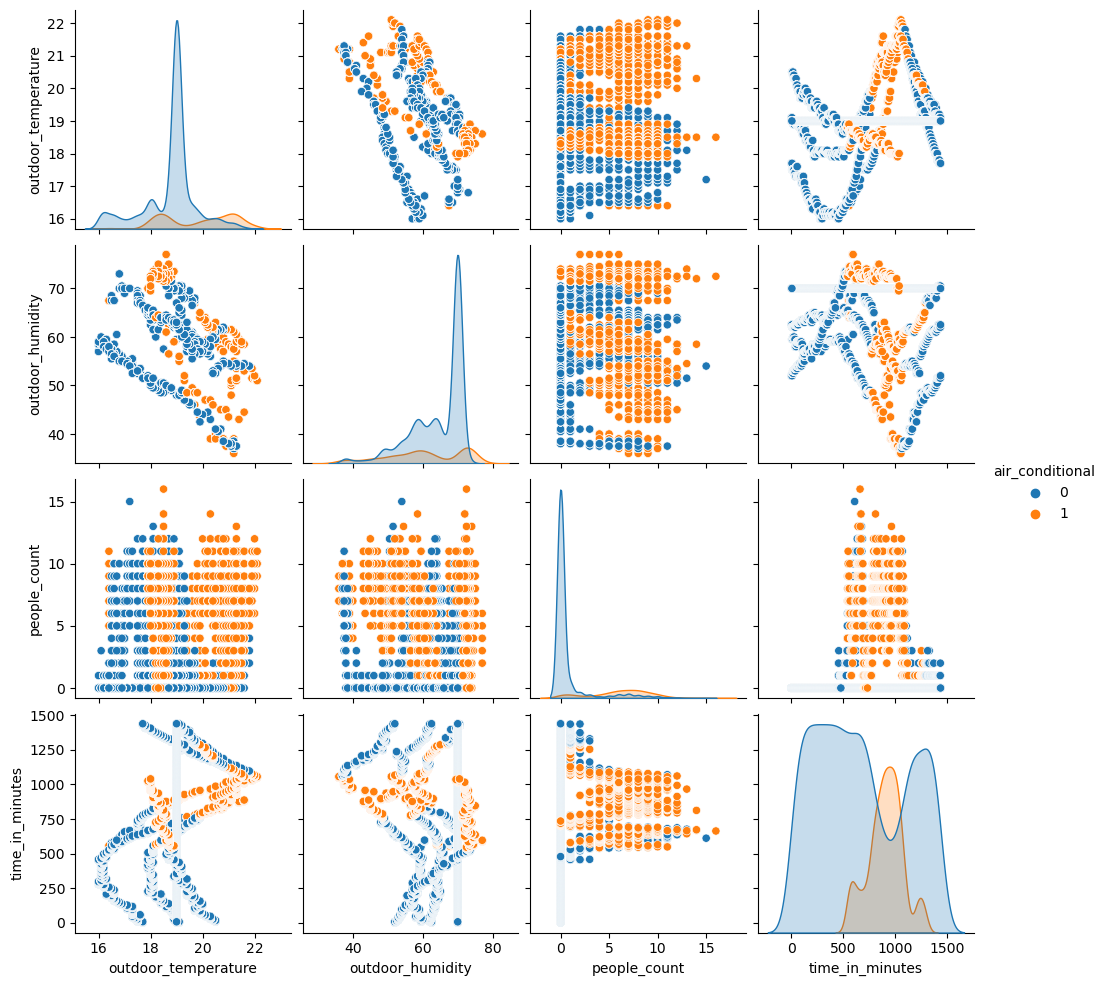

In [279]:
# 산점도 그리기
sns.pairplot(data_df_filter_by_environment, hue='air_conditional', vars=['outdoor_temperature', 'outdoor_humidity', 'people_count', 'time_in_minutes'])
plt.show()

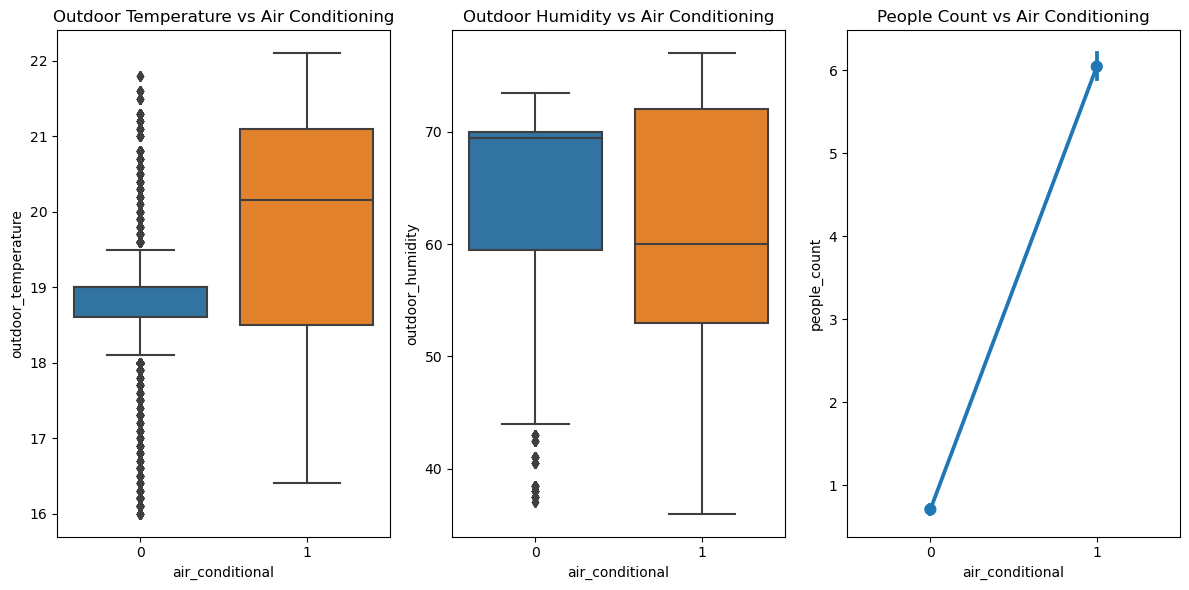

In [280]:
# 데이터 세트 설정
data = data_df_filter_by_environment

# 1. 외부 온도와 에어컨의 상관관계 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='air_conditional', y='outdoor_temperature', data=data)
plt.title('Outdoor Temperature vs Air Conditioning')

# 2. 외부 습도와 에어컨의 상관관계 시각화
plt.subplot(1, 3, 2)
sns.boxplot(x='air_conditional', y='outdoor_humidity', data=data)
plt.title('Outdoor Humidity vs Air Conditioning')

# 3. 재실 인원과 에어컨의 상관관계 시각화
plt.subplot(1, 3, 3)
sns.pointplot(x='air_conditional', y='people_count', data=data)
plt.title('People Count vs Air Conditioning')

plt.tight_layout()
plt.show()


- 시간에 따른 에어컨 사용량 분석

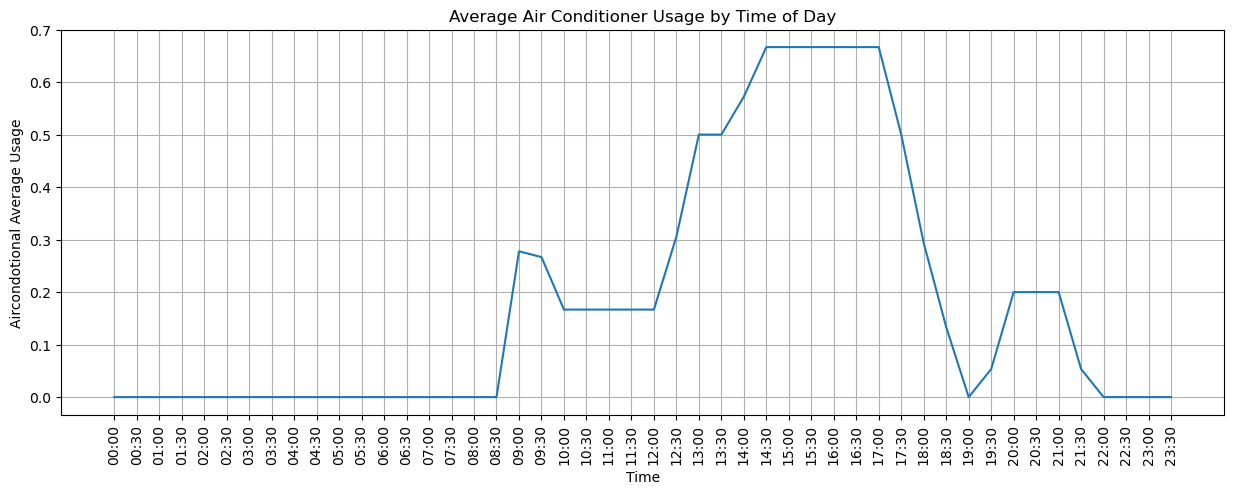

In [281]:
# grouped_by_time 인덱스를 하루 중 분으로 변환
minutes_since_midnight = [t.hour * 60 + t.minute for t in grouped_by_time.index]

# 데이터 시각화
fig, ax = plt.subplots(figsize=(15, 5))

# 선 그래프 그리기
ax.plot(minutes_since_midnight, grouped_by_time.values)

# 제목 및 라벨 설정
ax.set_title('Average Air Conditioner Usage by Time of Day')
ax.set_xlabel('Time')
ax.set_ylabel('Aircondotional Average Usage')

# x축 눈금 라벨 설정
# x축 눈금을 시간:분 형태로 표시
ax.set_xticks(minutes_since_midnight)  # 눈금 설정
ax.set_xticklabels([f'{t.hour:02}:{t.minute:02}' for t in grouped_by_time.index], rotation=90)

# 그리드 추가
ax.grid(True)

# 그래프 보여주기
plt.show()


### 분석 결과
1. 환경에 따른 에어컨 사용량 분석 : outdoor_temperature 또는 outdoor_humidity가 높을때 people_count가 함께 높을수록 에어컨을 키는 빈도가 늘어난다.
2. 시간에 따른 에어컨 사용량 분석 : 학생들이 입실하는 오전 9시, 점심시간이후이 12시부터 에어컨 사용량이 늘어난다. 학원이 마치는 시간인 6시 이후부터는 사용량이 줄어들다가 12시 반 이후가 되면 에어컨이 꺼질 확률이 높다.

### 모델링
1. 데이터 분할

In [282]:
model_data_df =  data_df_filter_by_environment.copy()
print(model_data_df.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            18.985865         59.459916    23.650000  46.000000   
09:01:00            18.985865         59.459916    23.300000  47.333333   
09:02:00            18.985865         59.459916    23.650000  46.000000   
09:03:00            18.985865         59.459916    23.233333  47.333333   
09:04:00            18.985865         59.459916    23.550000  46.000000   

          people_count  air_conditional  time_in_minutes  
09:00:00           4.0                0              540  
09:01:00           4.0                0              541  
09:02:00           4.0                0              542  
09:03:00           2.0                0              543  
09:04:00           5.0                0              544  


In [283]:
# 회귀모델용 훈련데이터와 테스트 데이터 분리
X_reg = model_data_df[['outdoor_temperature', 'outdoor_humidity', 'people_count', 'time_in_minutes']]
y_reg = model_data_df['air_conditional']

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [284]:
# 훈련데이터와 테스트 데이터 분리
X = model_data_df[['outdoor_temperature', 'outdoor_humidity', 'temperature', 'humidity', 'people_count', 'time_in_minutes']]
y = model_data_df['air_conditional']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. 모델 훈련 및 평가

In [285]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 준비
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
log_reg_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_reg_model.fit(X_reg_train, y_reg_train)

# 모델 평가
from sklearn.metrics import accuracy_score
log_reg_predictions = log_reg_model.predict(X_reg_test)
log_reg_accuracy = accuracy_score(y_reg_test, log_reg_predictions)

In [286]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [287]:
# XG 부스트
import xgboost as xgb

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

In [288]:
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy)

LogisticRegression Accuracy: 0.9247242050616483
RandomForest Accuracy: 0.9980532121998702
XGBoost Accuracy: 0.9967553536664504


- 모델의 일반화 성능을 더 정확하게 평가하기 위해 교차 검증 (cross-validation) 진행.
- 시계열 데이터를 다룰 때는 데이터 포인트 간의 시간적 종속성이 있기 때문에, 시간적 종속성을 무시하고 데이터를 무작위로 섞으면, 미래 데이터가 훈련 데이터에 포함될 수 있음. TimeSeriesSplit을 사용하여 데이터를 k개의 연속적인 폴드로 나누고, 각 폴드에서 i번째 폴드는 i-1번째 폴드의 모든 데이터를 포함하게 함으로서 시간의 흐름에 따라 점진적으로 훈련 데이터를 확장하는 방식으로 검증하게 함.

In [289]:
tscv = TimeSeriesSplit(n_splits=5)

def perform_cross_validation(model, X, y, cv):
    accuracy_scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(accuracy)
    
    return accuracy_scores

# 각 모델에 대해 교차 검증 실행
log_reg_scores = perform_cross_validation(log_reg_model, X, y, tscv)
rf_scores = perform_cross_validation(rf_model, X, y, tscv)
xgb_scores = perform_cross_validation(xgboost_model, X, y, tscv)

In [290]:
# 결과 출력
print("Logistic Regression CV Scores:", log_reg_scores)
print("Random Forest CV Scores:", rf_scores)
print("XGBoost CV Scores:", xgb_scores)

# 각 모델의 평균 정확도 계산
print("Average CV Accuracy - Logistic Regression: {:.2f}%".format(np.mean(log_reg_scores) * 100))
print("Average CV Accuracy - Random Forest: {:.2f}%".format(np.mean(rf_scores) * 100))
print("Average CV Accuracy - XGBoost: {:.2f}%".format(np.mean(xgb_scores) * 100))

Logistic Regression CV Scores: [0.9088074824629774, 0.7817614964925955, 1.0, 1.0, 0.7498051441932969]
Random Forest CV Scores: [0.9095869056897895, 0.7763055339049104, 1.0, 1.0, 0.6165237724084178]
XGBoost CV Scores: [0.897116134060795, 0.8347622759158223, 1.0, 1.0, 0.6204208885424786]
Average CV Accuracy - Logistic Regression: 88.81%
Average CV Accuracy - Random Forest: 86.05%
Average CV Accuracy - XGBoost: 87.05%


- 일부 폴드에서 100%의 정확도를 달성하며 일관성 없는 성능 분산을 보여줌. 특히, 일부 폴드에서는 상당히 낮은 정확도를 보임.
- 각 모델이 특정 데이터에 대해서 과적합되었을 가능성이 보임.

In [295]:
print(classification_report(y_test, log_reg_predictions))
print(classification_report(y_test, rf_predictions))
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1215
           1       0.87      0.76      0.81       326

    accuracy                           0.92      1541
   macro avg       0.90      0.86      0.88      1541
weighted avg       0.92      0.92      0.92      1541

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1215
           1       1.00      0.99      1.00       326

    accuracy                           1.00      1541
   macro avg       1.00      1.00      1.00      1541
weighted avg       1.00      1.00      1.00      1541

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1215
           1       0.99      0.99      0.99       326

    accuracy                           1.00      1541
   macro avg       0.99      1.00      1.00      1541
weighted avg       1.00      1.00      1.00      1541



3. 모델 선택

In [294]:
# # 모델 저장 경로와 파일 이름 설정
# MODEL_NAME = 'air_conditional_ai_model.joblib'
# MODEL_PATH = './' 

# # 모델 저장
# joblib.dump(rf_model, MODEL_PATH + MODEL_NAME)

- RandomForest Accuracy가 가장 정확도가 높은 분류기.